All stations: 3078 points
Used stations: 557 points
Built-in dataset failed: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
Downloaded from Natural Earth

Figure saved as 'fig1c.png' and 'fig1c.pdf'


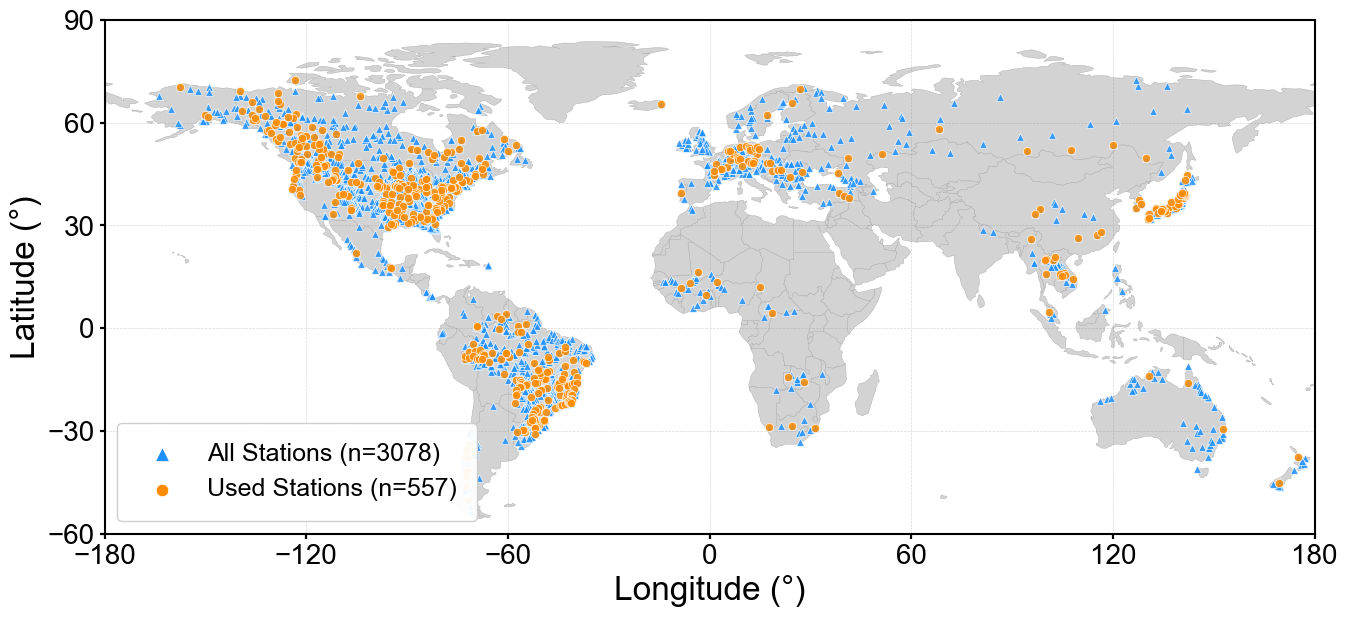

In [1]:
"""
Station Distribution Map Visualization
绘制全球站点分布图，区分全部站点和使用站点
"""

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box


# =============================================================================
# 配置参数
# =============================================================================

# 文件路径
INPUT_FILES = {
    'all_stations': '../1-buffer-match/GAGES_LATLON.csv',
    'kge_stations': '../3-process/half-processed/5.q_kge_med_modified_q50_iqr_node_1.5_noqa_VersionD.csv',
}

OUTPUT_FILES = {
    'png': 'fig1c.png',
    'pdf': 'fig1c.pdf',
}

# 颜色配置
COLORS = {
    'ocean': '#FFFFFF',
    'land': '#D3D3D3',
    'land_edge': '#A9A9A9',
    'all_stations': '#1E90FF',      # 道奇蓝
    'used_stations': '#FF8C00',     # 深橙色
    'marker_edge': '#FFFFFF',
}

# 图形配置
FIGURE_CONFIG = {
    'figsize': (14, 8),
    'dpi': 100,
    'save_dpi': 500,
}

# 地图范围
MAP_EXTENT = {
    'xlim': (-180, 180),
    'ylim': (-60, 90),
    'xticks': range(-180, 181, 60),
    'yticks': range(-60, 91, 30),
}


# =============================================================================
# 函数定义
# =============================================================================

def setup_matplotlib_style():
    """设置 matplotlib 全局样式"""
    plt.rcParams.update({
        'font.family': 'Arial',
        'font.size': 24,
        'axes.titlesize': 24,
        'axes.labelsize': 24,
        'axes.titlepad': 20,
        'axes.linewidth': 1.5,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'xtick.major.width': 1.6,
        'ytick.major.width': 1.6,
        'legend.fontsize': 20,
        'legend.framealpha': 0.95,
    })


def load_station_data():
    """加载站点数据"""
    # 读取全部站点
    df_all = pd.read_csv(INPUT_FILES['all_stations'])
    print(f"All stations: {len(df_all)} points")
    
    # 读取 KGE 站点并筛选使用的站点
    df_kge = pd.read_csv(INPUT_FILES['kge_stations']).dropna().drop_duplicates(subset='stationid')
    df_used = df_all[df_all['stationid'].isin(df_kge['stationid'])]
    print(f"Used stations: {len(df_used)} points")
    
    return df_all, df_used


def create_geodataframe(df):
    """将 DataFrame 转换为 GeoDataFrame"""
    return gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['lon'], df['lat']),
        crs='EPSG:4326'
    )


def load_world_map():
    """加载世界地图底图"""
    try:
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        print("Loaded Natural Earth dataset")
        return world
    except Exception as e:
        print(f"Built-in dataset failed: {e}")
    
    try:
        url = 'https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip'
        world = gpd.read_file(url)
        print("Downloaded from Natural Earth")
        return world
    except Exception as e:
        print(f"Download failed: {e}")
    
    # 后备方案：创建简单边界框
    return gpd.GeoDataFrame(
        {'geometry': [box(-180, -90, 180, 90)], 'name': ['World']},
        crs='EPSG:4326'
    )


def create_figure(world, gdf_all, gdf_used):
    """创建并配置图形"""
    fig, ax = plt.subplots(
        figsize=FIGURE_CONFIG['figsize'],
        dpi=FIGURE_CONFIG['dpi']
    )
    
    # 设置背景色
    fig.patch.set_facecolor(COLORS['ocean'])
    ax.set_facecolor(COLORS['ocean'])
    
    # 绘制陆地
    world.plot(
        ax=ax,
        color=COLORS['land'],
        edgecolor=COLORS['land_edge'],
        linewidth=0.3
    )
    
    # 绘制全部站点（三角形）
    gdf_all.plot(
        ax=ax,
        color=COLORS['all_stations'],
        edgecolor=COLORS['marker_edge'],
        markersize=30,
        alpha=0.85,
        linewidth=0.5,
        marker='^',
        zorder=2
    )
    
    # 绘制使用站点（圆形）
    gdf_used.plot(
        ax=ax,
        color=COLORS['used_stations'],
        edgecolor=COLORS['marker_edge'],
        markersize=35,
        alpha=0.85,
        linewidth=0.5,
        marker='o',
        zorder=3
    )
    
    return fig, ax


def configure_axes(ax):
    """配置坐标轴"""
    ax.set_xlim(*MAP_EXTENT['xlim'])
    ax.set_ylim(*MAP_EXTENT['ylim'])
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    # ax.set_title('Station Distribution Map', fontweight='bold', pad=15)
    ax.set_xticks(MAP_EXTENT['xticks'])
    ax.set_yticks(MAP_EXTENT['yticks'])
    ax.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.5)


def add_legend(ax, n_all, n_used):
    """添加图例"""
    legend_elements = [
        plt.scatter([], [], c=COLORS['all_stations'], s=100, marker='^',
                    edgecolors=COLORS['marker_edge'], linewidths=0.5,
                    label=f'All Stations (n={n_all})'),
        plt.scatter([], [], c=COLORS['used_stations'], s=80, marker='o',
                    edgecolors=COLORS['marker_edge'], linewidths=0.5,
                    label=f'Used Stations (n={n_used})'),
    ]
    
    ax.legend(
        handles=legend_elements,
        loc='lower left',
        fontsize=18,
        frameon=True,
        fancybox=True,
        shadow=False,
        borderpad=0.8
    )


def save_figure(fig):
    """保存图形"""
    plt.tight_layout()
    
    save_kwargs = {
        'bbox_inches': 'tight',
        'facecolor': COLORS['ocean'],
        'edgecolor': 'none',
    }
    
    plt.savefig(OUTPUT_FILES['png'], dpi=FIGURE_CONFIG['save_dpi'], **save_kwargs)
    plt.savefig(OUTPUT_FILES['pdf'], **save_kwargs)
    
    print(f"\nFigure saved as '{OUTPUT_FILES['png']}' and '{OUTPUT_FILES['pdf']}'")


# =============================================================================
# 主程序
# =============================================================================

def main():
    """主函数"""
    # 初始化
    setup_matplotlib_style()
    
    # 加载数据
    df_all, df_used = load_station_data()
    gdf_all = create_geodataframe(df_all)
    gdf_used = create_geodataframe(df_used)
    world = load_world_map()
    
    # 创建图形
    fig, ax = create_figure(world, gdf_all, gdf_used)
    configure_axes(ax)
    add_legend(ax, len(gdf_all), len(gdf_used))
    
    # 保存并显示
    save_figure(fig)
    plt.show()


if __name__ == '__main__':
    main()